# Jupyter Notebook: ged_analysis.ipynb

## 1. Import necessary libraries

In [76]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install ipywidgets

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Now import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## 2. Define utility functions (for loading, cleaning, computing metrics)

In [77]:
def load_approx_results(file_path, fill_n_density=None):
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string to ensure consistent dtype
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    numeric_cols = [
        'ged', 'accuracy', 'absolute_error', 'squared_error',
        'runtime', 'memory_usage_mb',
        'graph1_n', 'graph1_density', 'graph2_n', 'graph2_density'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if fill_n_density is not None:
        # Ensure fill DataFrame also has string-based IDs
        fill_n_density['graph_id_1'] = fill_n_density['graph_id_1'].astype(str)
        fill_n_density['graph_id_2'] = fill_n_density['graph_id_2'].astype(str)

        needed_cols = ['graph1_n', 'graph2_n', 'graph1_density', 'graph2_density']
        ref_cols = ['graph_id_1', 'graph_id_2'] + needed_cols
        ref = fill_n_density[ref_cols].drop_duplicates()

        merged = pd.merge(
            df, ref,
            how='left',
            on=['graph_id_1','graph_id_2'],
            suffixes=('', '_ref')
        )
        for c in needed_cols:
            merged[c] = np.where(
                merged[c].isna(),
                merged[f"{c}_ref"],
                merged[c]
            )
        drop_cols = [f"{c}_ref" for c in needed_cols if f"{c}_ref" in merged.columns]
        merged.drop(columns=drop_cols, inplace=True)
        df = merged

    df.dropna(subset=['graph_id_1','graph_id_2'], inplace=True)
    return df

def load_exact_results(file_path):
    """
    Load exact GED results from an XLSX file.
    Compute 'ged_exact' as the median of (min_ged, max_ged) if they differ,
    else min_ged (or max_ged).
    """
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    for col in ['min_ged', 'max_ged']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    def compute_ged_exact(row):
        if pd.notnull(row['min_ged']) and pd.notnull(row['max_ged']) and row['min_ged'] != row['max_ged']:
            return (row['min_ged'] + row['max_ged']) / 2.0
        else:
            return row['min_ged']  # or row['max_ged']

    df['ged_exact'] = df.apply(compute_ged_exact, axis=1)
    df.dropna(subset=['graph_id_1','graph_id_2','ged_exact'], inplace=True)
    return df


def compute_relative_accuracy(ged_approx, ged_exact):
    if ged_exact == 0 or ged_exact is None:
        return np.nan
    return 1 - abs(ged_approx - ged_exact) / ged_exact

## 3. Define file paths for each dataset & method

In [78]:
datasets = {
    "AIDS": {
        "HED":      r"C:\project_data\results\gedlib\AIDS\AIDS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\AIDS\AIDS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\AIDS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx"
    },
    "IMDB-BINARY": {
        "HED":      r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\IMDB-BINARY\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\IMDB-BINARY\merged\results.xlsx"
    },
    "PROTEINS": {
        "HED":      r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\PROTEINS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\PROTEINS\merged\results.xlsx"
    }
}

## 4. Load data for each dataset & method

In [79]:
data = {}

for dset, paths in datasets.items():
    df_simgnn = load_approx_results(paths["SimGNN"])
    df_exact  = load_exact_results(paths["Exact"])

    df_hed  = load_approx_results(paths["HED"], fill_n_density=df_simgnn)
    df_ipfp = load_approx_results(paths["IPFP"], fill_n_density=df_simgnn)
    # For consistency, fill SimGNN from itself:
    df_simgnn_filled = load_approx_results(paths["SimGNN"], fill_n_density=df_simgnn)

    # Merge approximate with exact (intersection in memory)
    df_hed  = pd.merge(df_hed,  df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_ipfp = pd.merge(df_ipfp, df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_simgnn_filled = pd.merge(df_simgnn_filled, df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))

    # Compute metrics
    for df_approx in [df_hed, df_ipfp, df_simgnn_filled]:
        if 'ged_exact' in df_approx.columns and 'ged' in df_approx.columns:
            df_approx['absolute_error'] = abs(df_approx['ged'] - df_approx['ged_exact'])
            df_approx['squared_error']  = (df_approx['ged'] - df_approx['ged_exact'])**2
            df_approx['accuracy']       = df_approx.apply(
                lambda row: compute_relative_accuracy(row['ged'], row['ged_exact'])
                            if pd.notnull(row['ged_exact']) else np.nan,
                axis=1
            )
            df_approx['graph_size'] = (df_approx['graph1_n'] + df_approx['graph2_n']) / 2.0
            df_approx['graph_density'] = (df_approx['graph1_density'] + df_approx['graph2_density']) / 2.0

    data[dset] = {
        "HED":    df_hed,
        "IPFP":   df_ipfp,
        "SimGNN": df_simgnn_filled
    }


## 5. Generate correlation plots for each dataset

In [80]:
from scipy.stats import gaussian_kde

def filter_valid_accuracy(df):
    """
    Example helper to keep only rows with accuracy > 0 (if desired).
    If you want all rows (including zero or negative?), remove this filter.
    """
    return df[df['accuracy'] >= 0].dropna(subset=['accuracy', 'graph_size', 'graph_density'])

def filter_common_pairs(dset):
    """
    Returns a dictionary with filtered DataFrames for each method (HED, IPFP, SimGNN)
    containing only the common graph pairs (i.e. rows where (graph_id_1, graph_id_2) appear in all three methods).
    """
    methods = ["HED", "IPFP", "SimGNN"]
    common_pairs = None
    for method in methods:
        df_method = data[dset][method]
        pairs = set(zip(df_method["graph_id_1"], df_method["graph_id_2"]))
        if common_pairs is None:
            common_pairs = pairs
        else:
            common_pairs = common_pairs.intersection(pairs)
    filtered = {}
    for method in methods:
        df_method = data[dset][method]
        filtered[method] = df_method[df_method.apply(lambda row: (row["graph_id_1"], row["graph_id_2"]) in common_pairs, axis=1)]
    return filtered


In [81]:
def plot_accuracy_hist_by_size(dset, bins=20):
    """
    For the chosen dataset `dset`, create density plots arranged vertically (one per method)
    for three graph-size categories:
      1) Small (<50 nodes)
      2) Medium (50–100 nodes)
      3) Large (>100 nodes)

    Each subplot shows the density curve (computed via a kernel density estimator) with fill under the curve.
    The methods (HED, IPFP, SimGNN) are ordered by their median accuracy.
    """
    methods = ["HED", "IPFP", "SimGNN"]

    def plot_density(ax, data_series, method_label):
        if data_series.empty:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
            return
        x_min, x_max = data_series.min(), data_series.max()
        x_range = np.linspace(x_min, x_max, 100)
        kde = gaussian_kde(data_series)
        y = kde(x_range)
        ax.plot(x_range, y, label=method_label)
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Categories: (Title, filter function)
    categories = [
        ("Small (<50 nodes)", lambda df: df["graph_size"] < 50),
        ("Medium (50–100 nodes)", lambda df: (df["graph_size"] >= 50) & (df["graph_size"] <= 100)),
        ("Large (>100 nodes)", lambda df: df["graph_size"] > 100)
    ]

    for cat_title, cat_filter in categories:
        # Gather per-method data and compute median accuracy
        method_data = []
        for method in methods:
            df_method = filter_valid_accuracy(data[dset][method])
            df_cat = df_method[cat_filter(df_method)]
            median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan
            method_data.append((method, df_cat, median_val))
        # Order methods by median accuracy (if no data, NaN is placed last)
        method_data_sorted = sorted(method_data, key=lambda x: (np.nan if np.isnan(x[2]) else x[2]))

        fig, axs = plt.subplots(nrows=len(methods), figsize=(8, 3*len(methods)), dpi=120, sharex=True)
        if len(methods) == 1:
            axs = [axs]
        for ax, (method, df_cat, median_val) in zip(axs, method_data_sorted):
            if not df_cat.empty:
                label = f"{method} (median={median_val:.2f})"
                plot_density(ax, df_cat["accuracy"], label)
            else:
                ax.text(0.5, 0.5, f"{method}: No data", horizontalalignment='center', verticalalignment='center')
            ax.set_ylabel("Density")
        plt.suptitle(f"{dset} — {cat_title} Accuracy Density by Method")
        plt.xlabel("Relative Accuracy")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [82]:
def plot_accuracy_hist_by_density(dset, density_threshold=0.1, bins=20):
    """
    For the chosen dataset `dset`, create density plots arranged vertically (one per method)
    for two graph-density categories:
      1) Sparse (graph_density < threshold)
      2) Dense (graph_density ≥ threshold)

    Each subplot shows the density curve (computed via a kernel density estimator) with fill under the curve.
    The methods (HED, IPFP, SimGNN) are ordered by their median accuracy.
    """
    methods = ["HED", "IPFP", "SimGNN"]

    def plot_density(ax, data_series, method_label):
        if data_series.empty:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
            return
        x_min, x_max = data_series.min(), data_series.max()
        x_range = np.linspace(x_min, x_max, 100)
        kde = gaussian_kde(data_series)
        y = kde(x_range)
        ax.plot(x_range, y, label=method_label)
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Categories: (Title, filter function)
    categories = [
        (f"Sparse (density < {density_threshold})", lambda df: df["graph_density"] < density_threshold),
        (f"Dense (density ≥ {density_threshold})", lambda df: df["graph_density"] >= density_threshold)
    ]

    for cat_title, cat_filter in categories:
        # Gather per-method data and compute median accuracy
        method_data = []
        for method in methods:
            df_method = filter_valid_accuracy(data[dset][method])
            df_cat = df_method[cat_filter(df_method)]
            median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan
            method_data.append((method, df_cat, median_val))
        # Order methods by median accuracy
        method_data_sorted = sorted(method_data, key=lambda x: (np.nan if np.isnan(x[2]) else x[2]))

        fig, axs = plt.subplots(nrows=len(methods), figsize=(8, 3*len(methods)), dpi=120, sharex=True)
        if len(methods) == 1:
            axs = [axs]
        for ax, (method, df_cat, median_val) in zip(axs, method_data_sorted):
            if not df_cat.empty:
                label = f"{method} (median={median_val:.2f})"
                plot_density(ax, df_cat["accuracy"], label)
            else:
                ax.text(0.5, 0.5, f"{method}: No data", horizontalalignment='center', verticalalignment='center')
            ax.set_ylabel("Density")
        plt.suptitle(f"{dset} — {cat_title} Accuracy Density by Method")
        plt.xlabel("Relative Accuracy")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


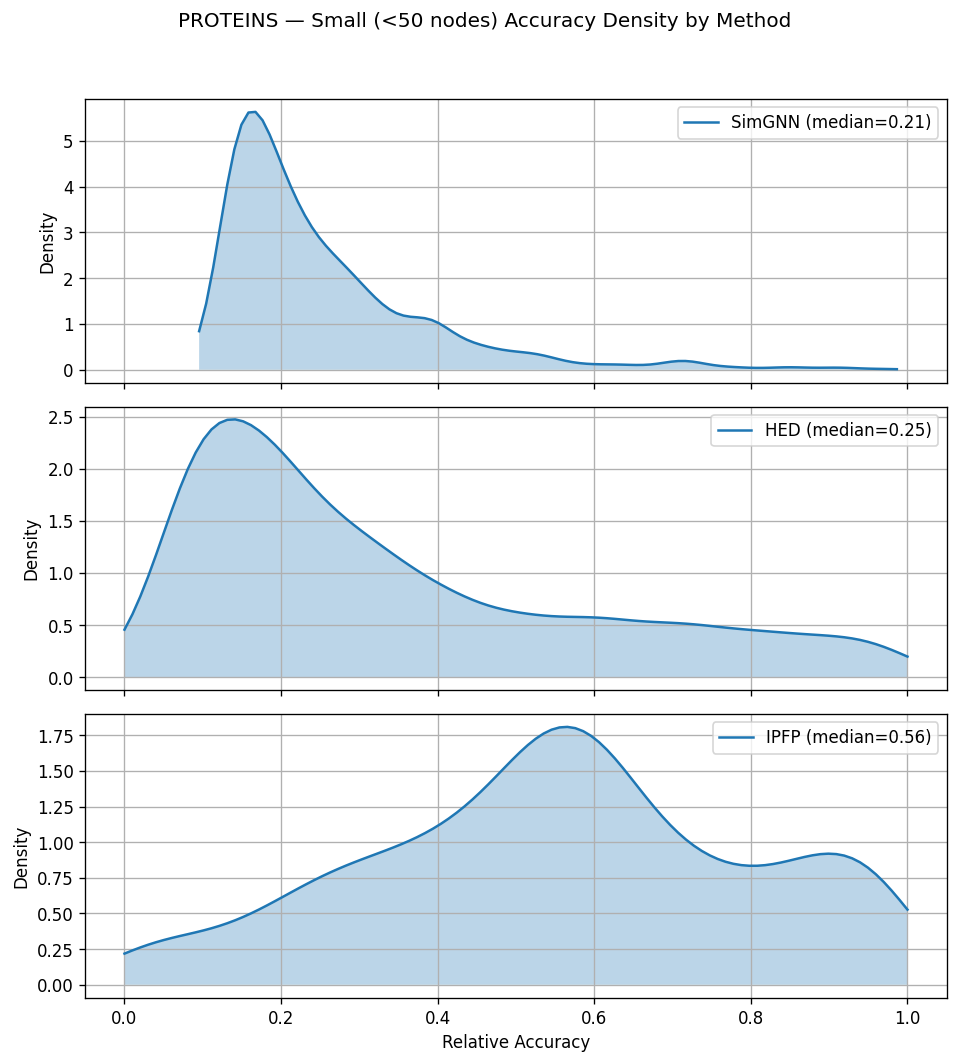

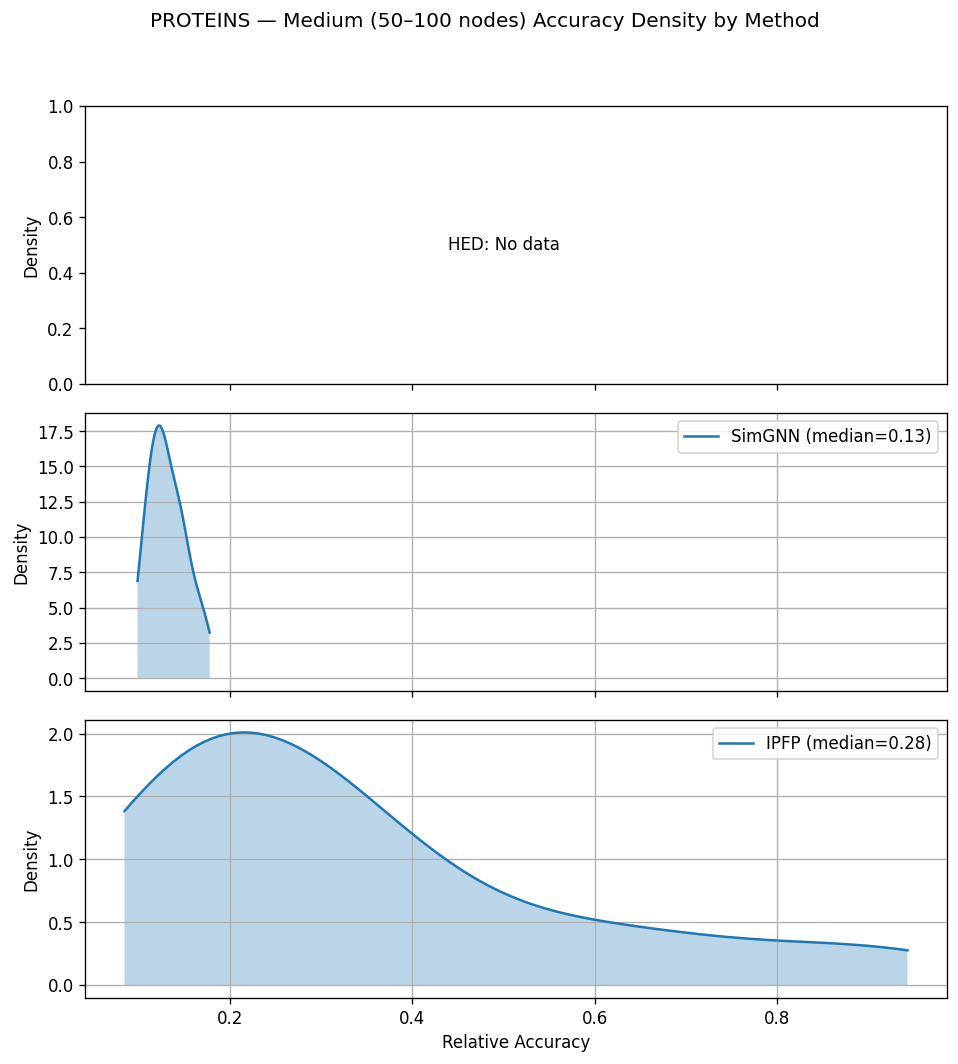

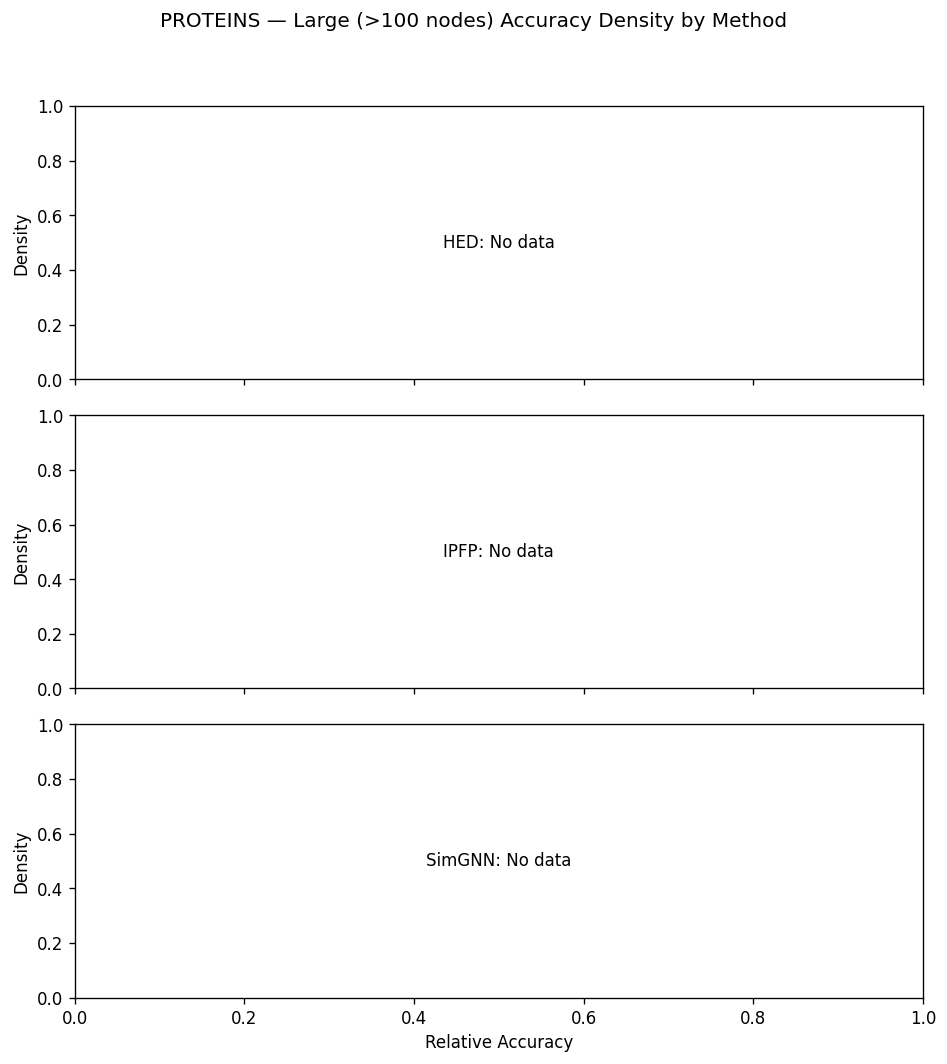

In [83]:
plot_accuracy_hist_by_size(dset="PROTEINS", bins=20)

## 7. Scatter plot for Accuracy Analysis

In [104]:
import matplotlib as mpl

def plot_accuracy_scatter(dset, method):
    """
    For the chosen dataset `dset` and given `method`, create a 2D hexbin plot
    comparing the approximate GED results (ged) against the exact GED results (ged_exact).

    Each hexagon is colored by the count of observations in that bin,
    using a custom lavender colormap from very light (#E6E6FA) to bright (#8A2BE2).
    The diagonal (y = x) represents the exact GED.
    The figure is sized to an HD-like resolution (1280x720).
    """

    # Define a custom lavender colormap from light to bright
    lavender_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "LavenderMap",
        ["#8A2BE2", "#B299FF", "#E6E6FA"]  # Light → Medium → Bright lavender
    )

    # Set HD-like resolution: 12.8" x 7.2" at 100 DPI ~ 1280 x 720 pixels
    plt.figure(figsize=(12.8, 7.2), dpi=100)

    # Collect all (x, y) points for the chosen method
    all_exact = []
    all_approx = []
    df_method = data[dset][method].dropna(subset=['ged', 'ged_exact'])
    all_exact.extend(df_method["ged_exact"].tolist())
    all_approx.extend(df_method["ged"].tolist())

    # Plot hexbin only if we have points
    if all_exact and all_approx:
        hb = plt.hexbin(
            all_exact,
            all_approx,
            gridsize=50,          # number of hexagons along each axis
            cmap=lavender_cmap,   # our custom lavender colormap
            mincnt=1              # only color bins that have at least one point
        )
        cb = plt.colorbar(hb)
        cb.set_label("Count")

        # Draw the diagonal
        lower = min(min(all_exact), min(all_approx))
        upper = max(max(all_exact), max(all_approx))
        plt.plot([lower, upper], [lower, upper], 'k--', label="Exact GED (y = x)")

    # Clamp axes to [0, 250]
    limit = 250
    plt.xlim(0, limit)
    plt.ylim(0, limit)

    plt.title(f"{dset} — Approximate GED vs Exact GED (Hexbin: {method})")
    plt.xlabel("Exact GED")
    plt.ylabel("Approximate GED")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

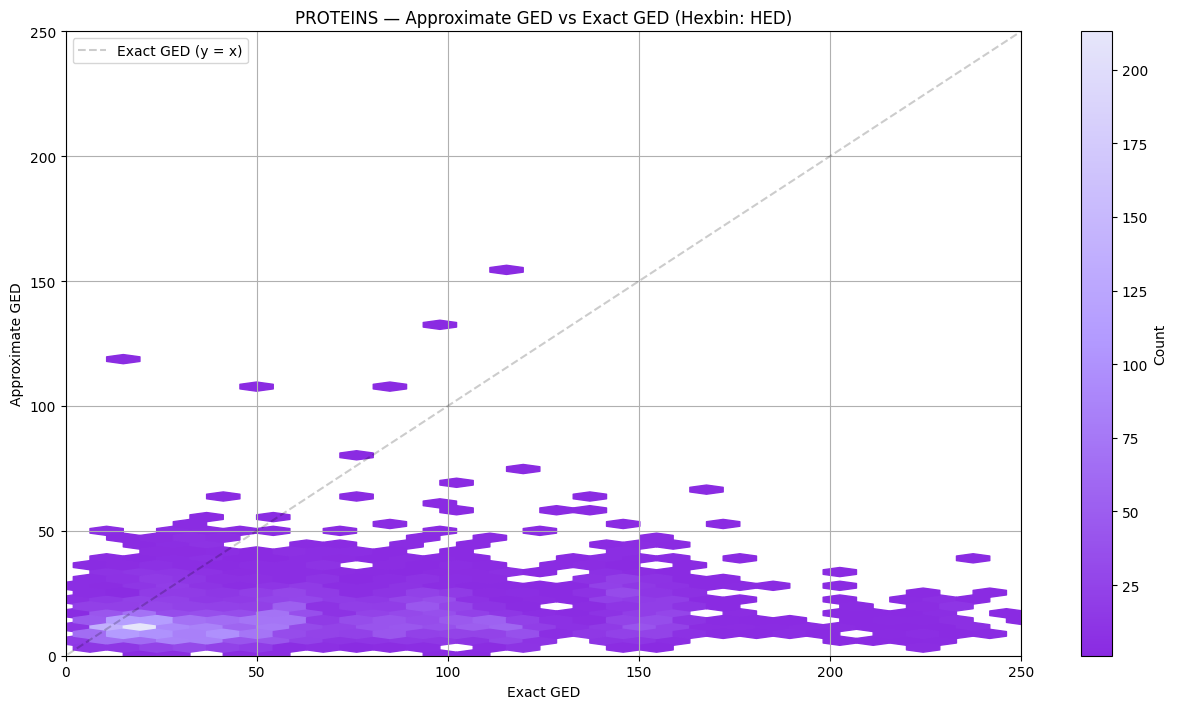

In [105]:
    plot_accuracy_scatter("PROTEINS", "HED")